In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import GridSearchCV


class ECommerceTrafficPredictor:
    """
    A class for processing e-commerce clickstream data and predicting website traffic.
    Handles data preprocessing, feature engineering, model training, and forecasting.
    """
    
    def __init__(self, data_path=None, df=None):
        """
        Initialize the predictor with either a data path or DataFrame.
        
        Args:
            data_path (str, optional): Path to the CSV file
            df (DataFrame, optional): Existing DataFrame with clickstream data
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")
            
        self.models = {}
        self.forecasts = {}
        self.metrics = {}
        self.hourly_traffic = None
        self.hourly_purchase = None
        self.holidays = None
        
    def preprocess_data(self):
        """
        Prepare data for analysis: handle missing values, convert timestamps,
        and extract time-based features.
        
        Returns:
            DataFrame: Processed DataFrame with date-time index
        """
        # Convert timestamp to datetime
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        
        # Handle missing values for categorical columns
        self.df.fillna({
            'Outcome': 'not_purchased', 
            'ProductID': 'no_product'
        }, inplace=True)
        
        # Extract time features
        self.df['Hour'] = self.df['Timestamp'].dt.hour
        self.df['DayOfWeek'] = self.df['Timestamp'].dt.dayofweek
        self.df['Month'] = self.df['Timestamp'].dt.month
        self.df['DayName'] = self.df['Timestamp'].dt.day_name()
        self.df['IsWeekend'] = self.df['DayOfWeek'].isin([5, 6]).astype(int)
        
        # Generate US holidays
        cal = USFederalHolidayCalendar()
        self.holidays = cal.holidays(start=self.df['Timestamp'].min(), 
                                end=self.df['Timestamp'].max())
        self.df['IsHoliday'] = self.df['Timestamp'].dt.normalize().isin(self.holidays).astype(int)
        
        return self.df
    
    def aggregate_hourly_traffic(self):
        """
        Aggregate traffic by hour and event type.
        
        Returns:
            DataFrame: Hourly traffic with event types as columns
        """
        # Set timestamp as index
        df_indexed = self.df.copy()
        df_indexed.set_index('Timestamp', inplace=True)
        
        # Resample to hourly frequency and count events
        hourly = df_indexed.groupby([pd.Grouper(freq='h'), 'EventType']).size().unstack(fill_value=0)
        
        # Add total traffic column
        hourly['Total'] = hourly.sum(axis=1)

        # Add view and purchase columns
        hourly['view'] = hourly.get('product_view', 0)
        hourly['purchase'] = hourly.get('purchase', 0)
        
        # Add time features for modeling
        hourly['Hour'] = hourly.index.hour
        hourly['DayOfWeek'] = hourly.index.dayofweek
        hourly['Month'] = hourly.index.month
        hourly['IsWeekend'] = hourly['DayOfWeek'].isin([5, 6]).astype(int)
        hourly['IsHoliday'] = hourly.index.normalize().isin(self.holidays).astype(int)
        
        self.hourly_traffic = hourly
        return hourly
    
    def aggregate_hourly_purchase(self):
        """
        Aggregate purchase data by hour.
        
        Returns:
            DataFrame: Hourly purchase data
        """
        # Set timestamp as index
        df_indexed = self.df.copy()
        df_indexed.set_index('Timestamp', inplace=True)
        
        # Resample to hourly frequency and sum purchases
        hourly_purchase = df_indexed[df_indexed['EventType'] == 'purchase'].resample('h').size()
        
        # Add total purchase column
        hourly_purchase = hourly_purchase.to_frame(name='TotalPurchase')
        hourly_purchase['TotalPurchase'] = hourly_purchase['TotalPurchase'].fillna(0)
        
        # Add time features for modeling
        hourly_purchase['Hour'] = hourly_purchase.index.hour
        hourly_purchase['DayOfWeek'] = hourly_purchase.index.dayofweek
        hourly_purchase['Month'] = hourly_purchase.index.month
        hourly_purchase['IsWeekend'] = hourly_purchase['DayOfWeek'].isin([5, 6]).astype(int)
        hourly_purchase['IsHoliday'] = hourly_purchase.index.normalize().isin(self.holidays).astype(int)
        self.hourly_purchase = hourly_purchase
        
        return hourly_purchase

    def plot_traffic_patterns(self):
        """
        Visualize traffic patterns by hour of day and day of week.
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Aggregate by hour of day
        hourly_pattern = self.hourly_traffic.groupby(self.hourly_traffic.index.hour)['Total'].mean()
        
        # Aggregate by day of week
        daily_pattern = self.hourly_traffic.groupby(self.hourly_traffic.index.dayofweek)['Total'].mean()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot hourly pattern
        sns.lineplot(x=hourly_pattern.index, y=hourly_pattern.values, ax=ax1, marker='o')
        ax1.set_title('Average Traffic by Hour of Day')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Average Traffic Volume')
        ax1.set_xticks(range(0, 24))
        
        # Plot daily pattern
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=days, y=daily_pattern.values, ax=ax2)
        ax2.set_title('Average Traffic by Day of Week')
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Average Traffic Volume')
        ax2.set_xticklabels(days, rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def plot_purchase_patterns(self):
        """
        Visualize purchase patterns by hour of day and day of week.
        """
        if self.hourly_purchase is None:
            self.aggregate_hourly_purchase()

        # Aggregate by hour of day
        hourly_purchase_pattern = self.hourly_purchase.groupby(self.hourly_purchase.index.hour)['TotalPurchase'].mean()
       
        # Aggregate by day of week
        daily_purchase_pattern = self.hourly_purchase.groupby(self.hourly_purchase.index.dayofweek)['TotalPurchase'].mean()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
       
        # Plot hourly purchase pattern
        sns.lineplot(x=hourly_purchase_pattern.index, y=hourly_purchase_pattern.values, ax=ax1, marker='o')
        ax1.set_title('Average Purchases by Hour of Day')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Average Purchase Volume')
        ax1.set_xticks(range(0, 24))
       
        # Plot daily purchase pattern
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=days, y=daily_purchase_pattern.values, ax=ax2)
        ax2.set_title('Average Purchases by Day of Week')
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Average Purchase Volume')
        ax2.set_xticklabels(days, rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_traffic_by_event_type(self):
        """
        Visualize traffic by event type.
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Plot traffic by event type
        event_types = self.hourly_traffic.columns[:-5]
        event_traffic = self.hourly_traffic[event_types].sum()
        event_traffic = event_traffic.sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=event_traffic.index, y=event_traffic.values)
        plt.title('Total Traffic by Event Type')
        plt.xlabel('Event Type')
        plt.ylabel('Total Traffic Volume')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_view_and_purchase(self):
        """
        Visualize product views and purchases.
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # use subplots to show views and purchases
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
        
        # Plot views
        sns.lineplot(x=self.hourly_traffic.index, y=self.hourly_traffic['view'], ax=ax1, color='blue')
        ax1.set_title('Hourly Views')
        ax1.set_ylabel('Views')
        ax1.set_xlabel('Date')
        ax1.grid(True)
       
        # Plot purchases
        sns.lineplot(x=self.hourly_traffic.index, y=self.hourly_traffic['purchase'], ax=ax2, color='orange')
        ax2.set_title('Hourly Purchases')
        ax2.set_ylabel('Purchases')
        ax2.set_xlabel('Date')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()
    
    def train_random_forest_model(self, target_col='Total', test_size=0.2, custom_params=None):
        """
        Train a Random Forest regression model for traffic prediction.
        
        Args:
            target_col (str): Target column to predict
            test_size (float): Proportion of data for testing
            custom_params (dict, optional): Custom hyperparameters
            
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()

        # Prepare features
        features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsHoliday']
        X = self.hourly_traffic[features].copy()
        y = self.hourly_traffic[target_col].copy()

        # Add lag features
        for i in [1, 2, 3, 6, 12, 24, 168]:
            X[f'lag_{i}'] = y.shift(i)
            
        mask = X.notna().all(axis=1)
        X, y = X[mask], y[mask]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

        # Use custom or default params
        model_params = custom_params or {
            'n_estimators': 100,
            'max_depth': 5,
            'random_state': 42
        }

        model = RandomForestRegressor(**model_params)
        model.fit(X_train, y_train)

        # Predict on train
        y_train_pred = model.predict(X_train)

        train_metrics = {
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'Train_MAE': mean_absolute_error(y_train, y_train_pred),
            'Train_R2': r2_score(y_train, y_train_pred),
            'Train_MAPE': np.mean(np.abs((y_train - y_train_pred) / (y_train + 1))) * 100
        }

        # Predict on test
        y_pred = model.predict(X_test)

        test_metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'MAPE': np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100
        }

        self.models['randomForest'] = model
        self.metrics['randomForest'] = {**train_metrics, **test_metrics}

        return X_train, X_test, y_train, y_test
    
    def train_xgboost_model(self, target_col='Total', test_size=0.2, custom_params=None):
        """
        Train an XGBoost regression model for traffic prediction.
        
        Args:
            target_col (str): Target column to predict
            test_size (float): Proportion of data for testing
            custom_params (dict, optional): Custom hyperparameters
            
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()

        features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsHoliday']
        X = self.hourly_traffic[features].copy()
        y = self.hourly_traffic[target_col].copy()

        for i in [1, 2, 3, 6, 12, 24, 168]:
            X[f'lag_{i}'] = y.shift(i)

        mask = X.notna().all(axis=1)
        X, y = X[mask], y[mask]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

        model_params = custom_params or {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'objective': 'reg:squarederror'
        }

        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train)

        # Predict on train
        y_train_pred = model.predict(X_train)

        train_metrics = {
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'Train_MAE': mean_absolute_error(y_train, y_train_pred),
            'Train_R2': r2_score(y_train, y_train_pred),
            'Train_MAPE': np.mean(np.abs((y_train - y_train_pred) / (y_train + 1))) * 100
        }

        # Predict on test
        y_pred = model.predict(X_test)
        test_metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'MAPE': np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100
        }

        self.models['xgboost'] = model
        self.metrics['xgboost'] = {**train_metrics, **test_metrics}

        return X_train, X_test, y_train, y_test

    def train_sarima_model(self, target_col='Total'):
        """
        Train a SARIMA model for time series forecasting.
        
        Args:
            target_col (str): Target column to predict
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Get time series data
        ts = self.hourly_traffic[target_col]
        
        # Split data
        train_size = int(len(ts) * 0.8)
        train, test = ts[:train_size], ts[train_size:]
 
        # Fit SARIMA model
        # ARIMA components (autoregressive, differencing, moving average)
        # Seasonal components (seasonal autoregressive, seasonal differencing, seasonal moving average, and seasonality period)
        # Order: (p,d,q) for trend, (P,D,Q,s) for seasonality
        # Using common values for hourly data
        model = SARIMAX(
            train,
            order=(2, 1, 2),          # Non-seasonal part (p,d,q)
            seasonal_order=(1, 1, 1, 24),  # Seasonal part (P,D,Q,s) - 24 for hourly data
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fit_model = model.fit(disp=False)

        # Predict on training set
        train_pred = fit_model.fittedvalues  # In-sample prediction

        # Calculate train metrics
        train_metrics = {
            'Train_RMSE': np.sqrt(mean_squared_error(train, train_pred)),
            'Train_MAE': mean_absolute_error(train, train_pred),
            'Train_R2': r2_score(train, train_pred),
            'Train_MAPE': np.mean(np.abs((train - train_pred) / (train + 1))) * 100
        }

        # Make predictions
        pred = fit_model.get_forecast(steps=len(test))
        y_pred = pred.predicted_mean
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mae = mean_absolute_error(test, y_pred)
        r2 = r2_score(test, y_pred)
        mape = np.mean(np.abs((test - y_pred) / (test + 1))) * 100
        
        test_metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        self.models['sarima'] = fit_model
        self.metrics['sarima'] = {**train_metrics, **test_metrics}
        
        return fit_model, (train, test, y_pred)
    
    def train_prophet_model(self, target_col='Total'):
        """
        Train a Facebook Prophet model for forecasting.
        
        Args:
            target_col (str): Target column to predict
        """
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        # Prepare data for Prophet
        prophet_df = self.hourly_traffic.reset_index()
        prophet_df = prophet_df.rename(columns={'Timestamp': 'ds', target_col: 'y'})
        prophet_df = prophet_df[['ds', 'y']]
        
        # Split data
        train_size = int(len(prophet_df) * 0.8)
        train = prophet_df[:train_size]
        test = prophet_df[train_size:]
        
        # Train Prophet model
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.05
        )
        model.fit(train)

        # Predict on the training set
        train_forecast = model.predict(train)

        y_train_pred = train_forecast['yhat'].values
        y_train_true = train['y'].values

        # Calculate train metrics
        train_metrics = {
            'Train_RMSE': np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
            'Train_MAE': mean_absolute_error(y_train_true, y_train_pred),
            'Train_R2': r2_score(y_train_true, y_train_pred),
            'Train_MAPE': np.mean(np.abs((y_train_true - y_train_pred) / (y_train_true + 1))) * 100
        }
        
        # Make predictions for the test period
        future = model.make_future_dataframe(periods=len(test), freq='h')
        forecast = model.predict(future)
        
        # Extract predictions for the test period
        y_pred = forecast['yhat'].iloc[-len(test):].values
        y_true = test['y'].values
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
        
        test_metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        self.models['prophet'] = model
        self.metrics['prophet'] = {**train_metrics, **test_metrics}
        
        return model, (train, test, forecast)

    def tune_model_hyperparameters(self, model, param_grid, X, y, cv=3, n_jobs=-1, verbose=1):
        """
        Perform hyperparameter tuning for models using GridSearchCV.
        
        Args:
            model (object): Model to tune (XGBoost, RandomForestRegressor)
            X (DataFrame): Feature matrix
            y (Series): Target variable
            cv (int): Number of cross-validation folds
            n_jobs (int): Number of parallel jobs
            verbose (int): Verbosity level for GridSearchCV
            
        Returns:
            model (RandomForestRegressor): Best estimator after tuning
            best_params (dict): Best hyperparameters
        """
        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2']
            }

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_mean_squared_error',
            n_jobs=n_jobs,
            verbose=verbose
        )
        grid_search.fit(X, y)

        print(f"Best Params for {model.__class__.__name__}: {grid_search.best_params_}")
        
        return grid_search.best_estimator_, grid_search.best_params_
 
    def compare_models(self):
        """
        Compare performance metrics of all trained models.
        
        Returns:
            DataFrame: Metrics for all models
        """
        if not self.metrics:
            raise ValueError("No models have been trained yet")
            
        metrics_df = pd.DataFrame(self.metrics).T
        
        # Visualize comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics_df.plot(kind='bar', ax=ax)
        plt.title("Model Comparison: Forecast Accuracy Metrics")
        plt.ylabel("Score")
        plt.xlabel("Model")
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
        
        return metrics_df
    
    def forecast_future_traffic(self, model_name='xgboost', hours=24):
        """
        Forecast future traffic using the specified model.
        
        Args:
            model_name (str): Name of the model to use ('xgboost', 'sarima', or 'prophet')
            hours (int): Number of hours to forecast ahead
            
        Returns:
            DataFrame: Forecasted traffic
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} has not been trained yet")
            
        if self.hourly_traffic is None:
            self.aggregate_hourly_traffic()
            
        if model_name == 'xgboost' or model_name == 'randomForest':
            # For XGBoost and Random Forest, we need to create a future feature matrix
            # Create future feature matrix
            last_timestamp = self.hourly_traffic.index[-1]
            future_dates = pd.date_range(start=last_timestamp + timedelta(hours=1), 
                                        periods=hours, freq='h')
            
            future_features = pd.DataFrame(index=future_dates)
            future_features['Hour'] = future_features.index.hour
            future_features['DayOfWeek'] = future_features.index.dayofweek
            future_features['Month'] = future_features.index.month
            future_features['IsWeekend'] = future_features['DayOfWeek'].isin([5, 6]).astype(int)
            
            # Check for holidays
            cal = USFederalHolidayCalendar()
            holidays = cal.holidays(start=future_features.index.min(), 
                                    end=future_features.index.max())
            future_features['IsHoliday'] = future_features.index.normalize().isin(holidays).astype(int)
            
            # Add lag features
            traffic_series = self.hourly_traffic['Total']
            for i in [1, 2, 3, 6, 12, 24, 168]:
                # For each prediction, we need to use the most recent available data
                traffic_with_pred = traffic_series.copy()
                
                for idx, future_date in enumerate(future_dates):
                    lag_dates = {}
                    for lag in [1, 2, 3, 6, 12, 24, 168]:
                        lag_date = future_date - timedelta(hours=lag)
                        if lag_date in traffic_with_pred.index:
                            lag_dates[f'lag_{lag}'] = traffic_with_pred[lag_date]
                        else:
                            # If we're forecasting far enough, we might need predictions we just made
                            lag_idx = idx - lag
                            if lag_idx >= 0:
                                lag_dates[f'lag_{lag}'] = future_features['Predicted'][lag_idx]
                            else:
                                # Default to the last known value if we can't find it
                                lag_dates[f'lag_{lag}'] = traffic_with_pred.iloc[-1]
                    
                    # Add lag features to future_features
                    for lag, value in lag_dates.items():
                        future_features.loc[future_date, lag] = value
                    
                    # Make prediction for this hour
                    X_pred = future_features.loc[future_date:future_date]
                    pred = self.models[model_name].predict(X_pred.drop(columns=['Predicted'], errors='ignore'))[0]
                    future_features.loc[future_date, 'Predicted'] = pred
                    
                    # Add prediction to our series for next iteration
                    traffic_with_pred[future_date] = pred
            
            forecast = future_features[['Predicted']].rename(columns={'Predicted': 'Traffic'})
            
        elif model_name == 'sarima':
            # For SARIMA, we can directly forecast future values
            forecast_obj = self.models['sarima'].get_forecast(steps=hours)
            predictions = forecast_obj.predicted_mean
            confidence_intervals = forecast_obj.conf_int()
            
            forecast = pd.DataFrame({
                'Traffic': predictions,
                'Lower_CI': confidence_intervals.iloc[:, 0],
                'Upper_CI': confidence_intervals.iloc[:, 1]
            })
            
        elif model_name == 'prophet':
            # For Prophet, create future dataframe and predict
            model = self.models['prophet']
            future = model.make_future_dataframe(periods=hours, freq='h')
            prophet_forecast = model.predict(future)
            
            # Extract just the future period
            future_forecast = prophet_forecast.iloc[-hours:]
            
            forecast = pd.DataFrame({
                'Traffic': future_forecast['yhat'],
                'Lower_CI': future_forecast['yhat_lower'],
                'Upper_CI': future_forecast['yhat_upper']
            }, index=future_forecast['ds'])
        
        self.forecasts[model_name] = forecast
        return forecast
    
    def plot_forecasts(self, hours_to_show_historical=48):
        """
        Plot all forecasts together with historical data.
        
        Args:
            hours_to_show_historical (int): Number of historical hours to include in plot
        """
        if not self.forecasts:
            raise ValueError("No forecasts have been generated yet")
            
        # Get historical data
        historical = self.hourly_traffic['Total']
        historical_to_show = historical[-hours_to_show_historical:]
        
        # Create plot
        plt.figure(figsize=(14, 8))
        
        # Plot historical data
        plt.plot(historical_to_show.index, historical_to_show, 'k-', label='Historical Traffic')
        
        # Plot each forecast
        colors = ['blue', 'red', 'green']
        for i, (model_name, forecast) in enumerate(self.forecasts.items()):
            plt.plot(forecast.index, forecast['Traffic'], 
                     color=colors[i % len(colors)], 
                     label=f'{model_name.upper()} Forecast')
            
            # Plot confidence intervals if available
            if 'Lower_CI' in forecast.columns and 'Upper_CI' in forecast.columns:
                plt.fill_between(forecast.index, 
                                forecast['Lower_CI'], 
                                forecast['Upper_CI'],
                                color=colors[i % len(colors)], 
                                alpha=0.2)
        
        plt.title('Website Traffic Forecast')
        plt.xlabel('Date')
        plt.ylabel('Traffic Volume')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def identify_peak_times(self, forecast, threshold_percentile=90):
        """
        Identify peak traffic times in the forecast.
        
        Args:
            forecast (DataFrame): Forecasted traffic
            threshold_percentile (int): Percentile threshold for identifying peaks
            
        Returns:
            DataFrame: Peak traffic times
        """
        # Calculate threshold
        threshold = np.percentile(forecast['n'], threshold_percentile)
        
        # Identify peaks
        peaks = forecast[forecast['Traffic'] >= threshold].copy()
        peaks['IsPeak'] = True
        
        return peaks


In [2]:
# Initialize with data
predictor = ECommerceTrafficPredictor('./ecommerce_clickstream_transactions.csv')

In [3]:
# initial exploratory data analysis
print("Initial Data Overview:")
print(predictor.df.head())
print(f"\nData contains {len(predictor.df)} records \n")
print(f"Data contains {len(predictor.df['ProductID'].unique())} unique products \n")
print(f"Data contains {len(predictor.df['UserID'].unique())} unique users \n")
print(f"Data contains {len(predictor.df['EventType'].unique())} unique event types \n")
print("Data contains the following columns:")
print(predictor.df.columns.tolist())
print("\n")

Initial Data Overview:
   UserID  SessionID                   Timestamp     EventType  ProductID  \
0       1          1  2024-07-07 18:00:26.959902     page_view        NaN   
1       1          1  2024-03-05 22:01:00.072000     page_view        NaN   
2       1          1  2024-03-23 22:08:10.568453  product_view  prod_8199   
3       1          1  2024-03-12 00:32:05.495638   add_to_cart  prod_4112   
4       1          1  2024-02-25 22:43:01.318876   add_to_cart  prod_3354   

   Amount Outcome  
0     NaN     NaN  
1     NaN     NaN  
2     NaN     NaN  
3     NaN     NaN  
4     NaN     NaN  

Data contains 74817 records 

Data contains 8748 unique products 

Data contains 1000 unique users 

Data contains 7 unique event types 

Data contains the following columns:
['UserID', 'SessionID', 'Timestamp', 'EventType', 'ProductID', 'Amount', 'Outcome']




In [4]:
# check summary info
print("Data Summary Info:")
predictor.df.info()

Data Summary Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74817 entries, 0 to 74816
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserID     74817 non-null  int64  
 1   SessionID  74817 non-null  int64  
 2   Timestamp  74817 non-null  object 
 3   EventType  74817 non-null  object 
 4   ProductID  32113 non-null  object 
 5   Amount     10682 non-null  float64
 6   Outcome    10682 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.0+ MB


In [5]:
# Check for missing values
print("Missing Values Overview:")
predictor.df.isnull().sum()

Missing Values Overview:


UserID           0
SessionID        0
Timestamp        0
EventType        0
ProductID    42704
Amount       64135
Outcome      64135
dtype: int64

In [6]:
# Check for duplicates
print("Duplicate Records Overview:")
print(f"Number of duplicate records: {predictor.df.duplicated().sum()}")

Duplicate Records Overview:
Number of duplicate records: 0


In [7]:
# Check for data types
print("Data Types Overview:")
predictor.df.dtypes

Data Types Overview:


UserID         int64
SessionID      int64
Timestamp     object
EventType     object
ProductID     object
Amount       float64
Outcome       object
dtype: object

In [8]:
# Check for data distribution
print("Data Distribution Overview:")
predictor.df.describe(include=np.number)

Data Distribution Overview:


,UserID,SessionID,Amount
count,74817.000000,74817.000000,10682.000000
mean,500.740741,5.509777,253.189758
std,288.945183,2.869337,143.043974
min,1.000000,1.000000,5.131843
25%,251.000000,3.000000,130.933965
50%,501.000000,6.000000,253.112517
75%,751.000000,8.000000,378.832078
max,1000.000000,10.000000,499.981538


In [9]:
# Check for correlations
print("Correlation Overview:")
predictor.df.corr(numeric_only=True)

Correlation Overview:


,UserID,SessionID,Amount
UserID,1.000000,-0.002100,0.019444
SessionID,-0.002100,1.000000,-0.006819
Amount,0.019444,-0.006819,1.000000


In [10]:
# Preprocess data
predictor.preprocess_data().head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome,Hour,DayOfWeek,Month,DayName,IsWeekend,IsHoliday
0,1,1,2024-07-07 18:00:26.959902,page_view,no_product,NaN,not_purchased,18,6,7,Sunday,1,0
1,1,1,2024-03-05 22:01:00.072000,page_view,no_product,NaN,not_purchased,22,1,3,Tuesday,0,0
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,not_purchased,22,5,3,Saturday,1,0
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,not_purchased,0,1,3,Tuesday,0,0
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,not_purchased,22,6,2,Sunday,1,0


In [11]:
# Aggregate to hourly traffic
hourly_data = predictor.aggregate_hourly_traffic()
print(f"Aggregated {len(hourly_data)} hours of traffic data")

Aggregated 4931 hours of traffic data


/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_56875/3641293256.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days, rotation=45)


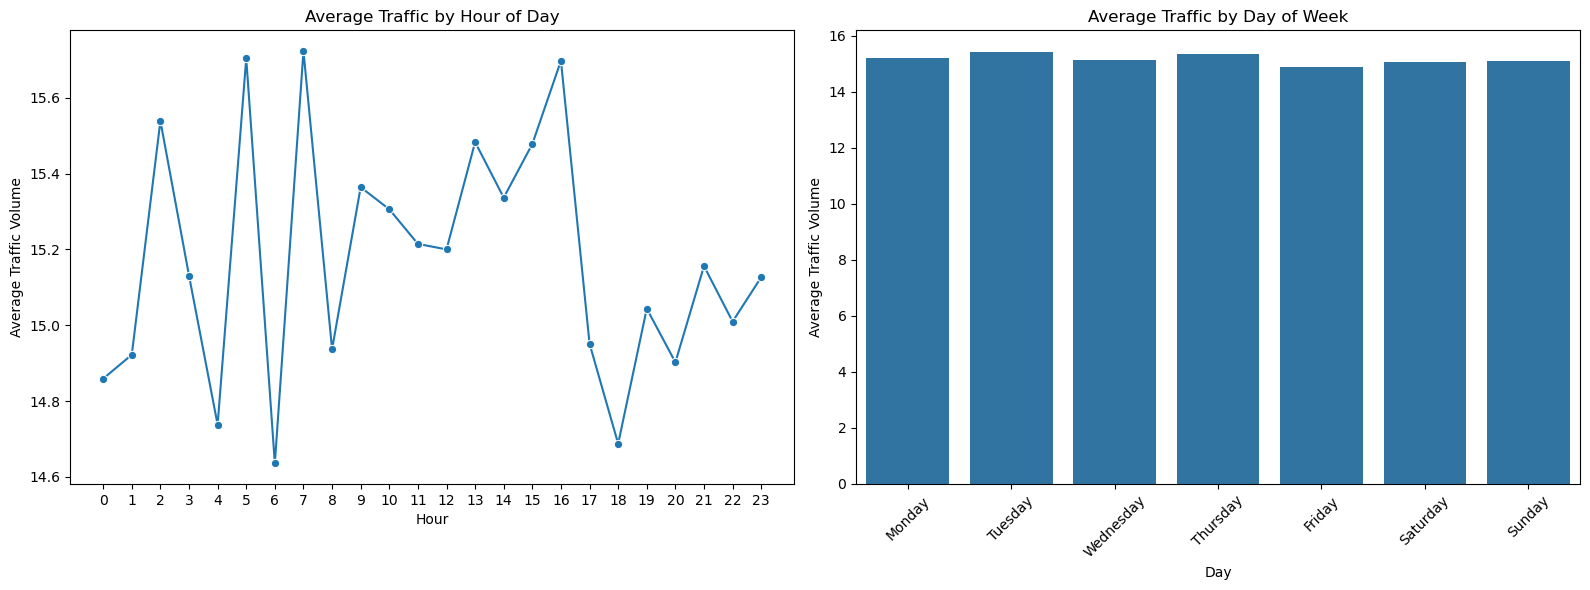

In [12]:
# Visualize traffic patterns
predictor.plot_traffic_patterns()

In [13]:
# Aggregate to purchase traffic
purchase_data = predictor.aggregate_hourly_traffic()
print(f"Aggregated {len(purchase_data)} purchase data")

Aggregated 4931 purchase data


/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_56875/3641293256.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(days, rotation=45)


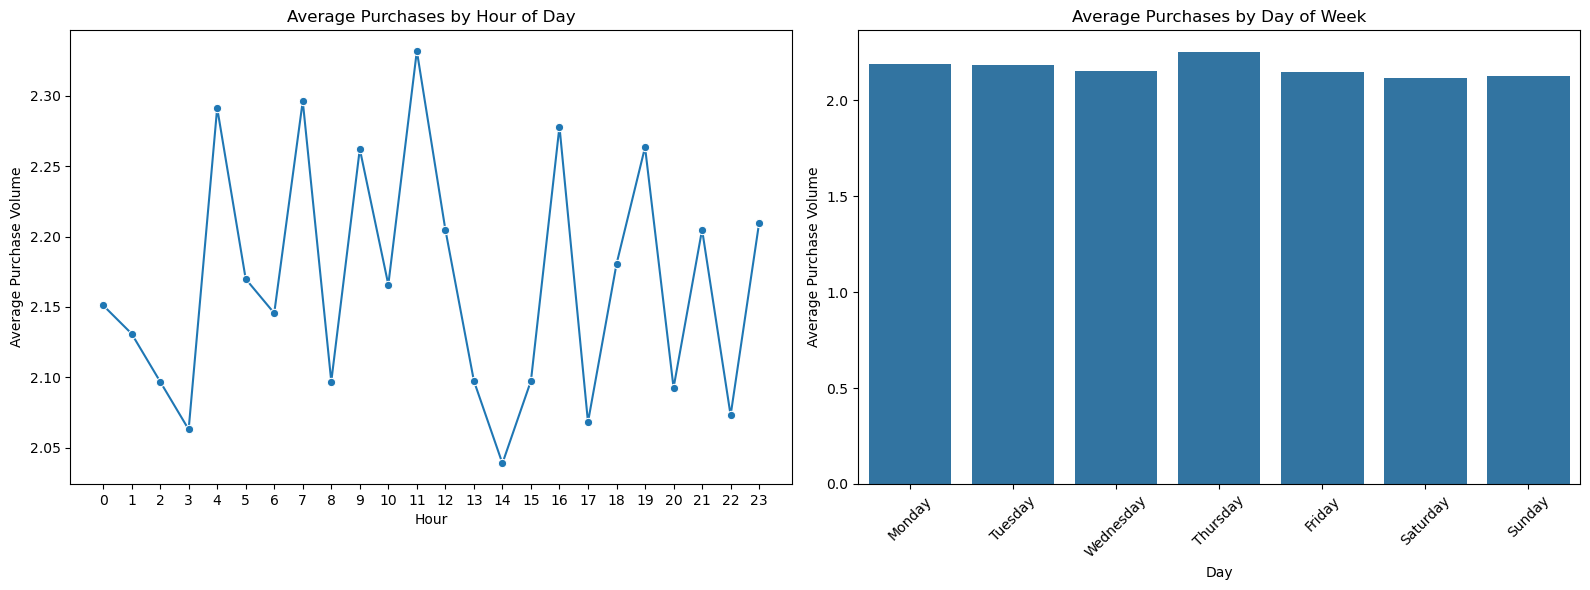

In [14]:
# Visualize purchase patterns
predictor.plot_purchase_patterns()

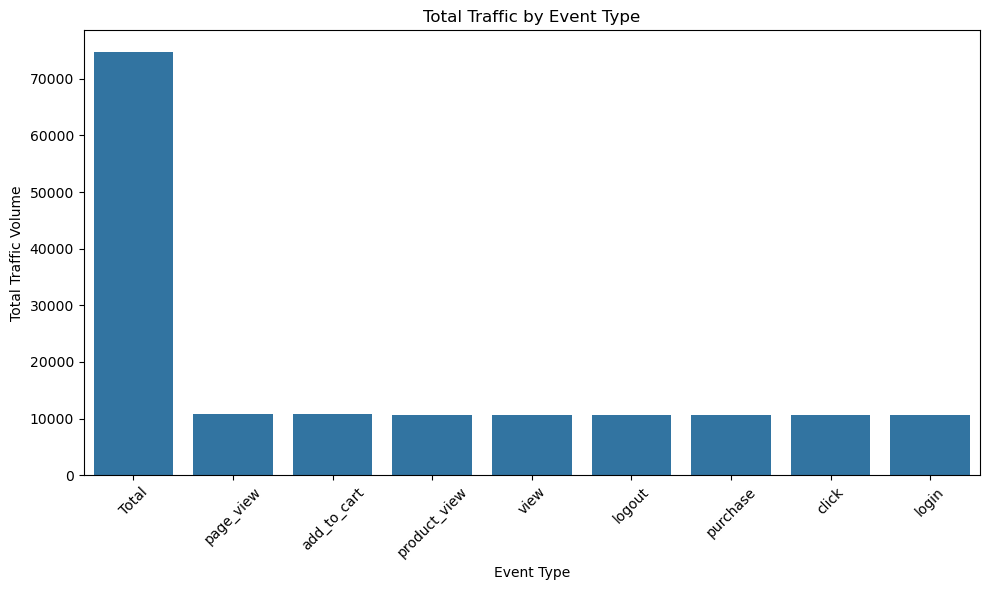

In [15]:
predictor.plot_traffic_by_event_type()

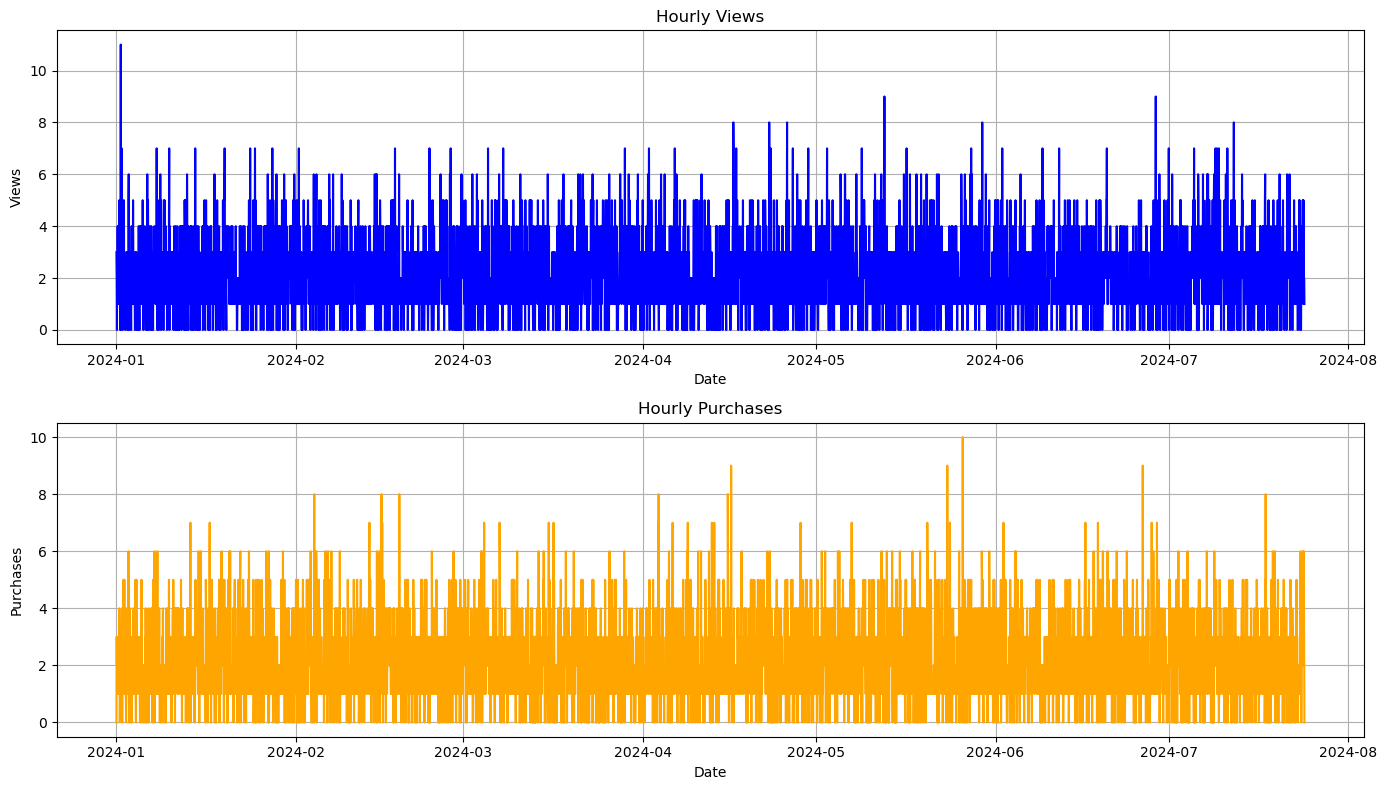

In [16]:
predictor.plot_view_and_purchase()

In [17]:
# Train models: XGBoost
print("Training with XGBoost model...")
try:
    X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = predictor.train_xgboost_model()
    print("Training with XGBoost model complete.")
except Exception as e:
    print(f"Error in training XGBoost model: {e}")

Training with XGBoost model...
Training with XGBoost model complete.


In [18]:
# Train models: Random Forest
print("Training with RandomForest model...")
try:
    X_rf_train, X_rf_test, y_rf_train, y_rf_test = predictor.train_random_forest_model()
    print("Training with RandomForest model complete.")
except Exception as e:
    print(f"Error in training RandomForest model: {e}")

Training with RandomForest model...
Training with RandomForest model complete.


In [ ]:
# Train models: SARIMA
print("Training SARIMA model...")
if predictor.train_sarima_model():
    print("Training SARIMA model complete.")

Training SARIMA model...


In [ ]:
# Train models: Prophet
print("Training Prophet model...")
if predictor.train_prophet_model():
    print("Training Prophet model complete.")

16:19:00 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


16:19:00 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model complete...


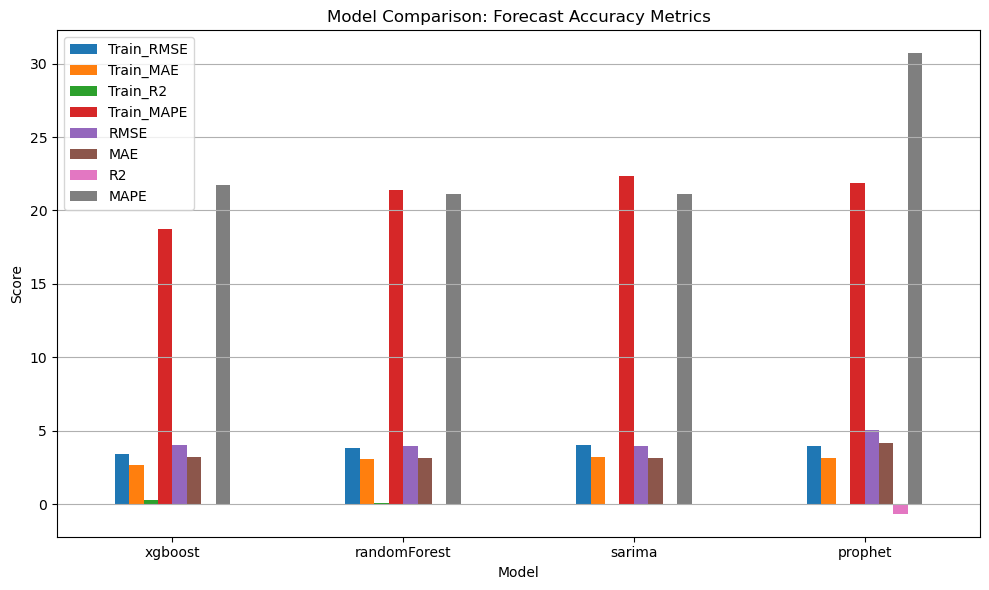


Model Comparison:


,Train_RMSE,Train_MAE,Train_R2,Train_MAPE,RMSE,MAE,R2,MAPE
xgboost,3.402914,2.700781,0.258135,18.750508,4.012008,3.207642,-0.043278,21.714513
randomForest,3.834086,3.082078,0.058227,21.365640,3.934342,3.133375,-0.003276,21.134175
sarima,4.059574,3.246477,-0.054541,22.365661,3.932539,3.147375,-0.008479,21.154487
prophet,3.939290,3.155119,0.007025,21.862944,5.025984,4.146677,-0.647262,30.697336


In [ ]:
# Compare models
metrics = predictor.compare_models()
print("\nModel Comparison:")
metrics

In [ ]:
# Generate forecasts before hyperparameter tuning 
print("\nGenerating forecasts before hyperparameter tuning...")
best_model = metrics['RMSE'].idxmin()  # Choose model with lowest RMSE
print(f"Best model based on RMSE: {best_model}")


Generating forecasts before hyperparameter tuning...
Best model based on RMSE: sarima


In [ ]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model, xgb_best_params = predictor.tune_model_hyperparameters(
    model=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=xgb_param_grid,
    X=X_xgb_train,
    y=y_xgb_train,
)

Fitting 3 folds for each of 4374 candidates, totalling 13122 fits


In [ ]:
params = {
    **xgb_best_params,
    'objective': 'reg:squarederror',
    'random_state': 42
}

try:
    predictor.train_xgboost_model(custom_params=params)
    print("Training XGBoost model with tuned parameters complete.")
except Exception as e:
    print(f"Error in training XGBoost model with tuned parameters: {e}")

Training XGBoost model with tuned parameters complete...


In [ ]:
rf_model, rf_best_params = predictor.tune_model_hyperparameters(
    RandomForestRegressor(random_state=42),
    None,
    X_rf_train, 
    y_rf_train
)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Params for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
params = {
    **rf_best_params,
    'random_state': 42
}

try:
    predictor.train_random_forest_model(custom_params=params)
    print("Training RandomForest model with tuned parameters complete.")
except Exception as e:
    print(f"Error in training RandomForest model with tuned parameters: {e}")

Training RandomForest model with tuned parameters complete...


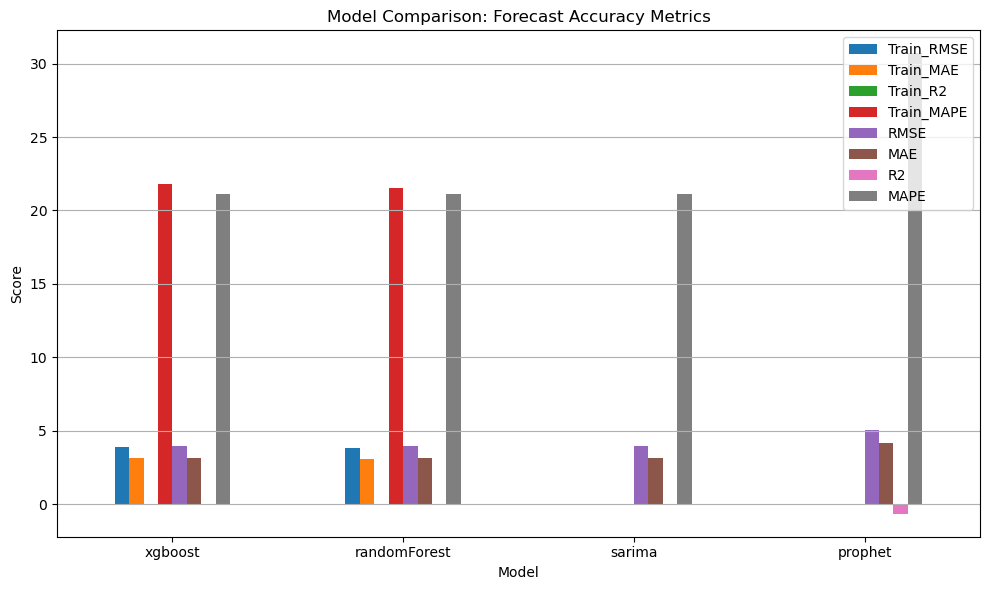


Model Comparison:


,Train_RMSE,Train_MAE,Train_R2,Train_MAPE,RMSE,MAE,R2,MAPE
xgboost,3.918387,3.139680,0.016357,21.779333,3.929158,3.129526,-0.000633,21.092100
randomForest,3.860223,3.099396,0.045343,21.498159,3.934783,3.134511,-0.003501,21.137521
sarima,NaN,NaN,NaN,NaN,3.932539,3.147375,-0.008479,21.154487
prophet,NaN,NaN,NaN,NaN,5.025984,4.146677,-0.647262,30.697336


In [ ]:
# Compare models
metrics = predictor.compare_models()
print("\nModel Comparison:")
metrics

In [ ]:
# Generate forecasts
print("\nGenerating forecasts after hyperparameter tuning...")
best_model = metrics['RMSE'].idxmin()  # Choose model with lowest RMSE
print(f"Best model based on RMSE: {best_model}")


Generating forecasts after hyperparameter tuning...
Best model based on RMSE: xgboost


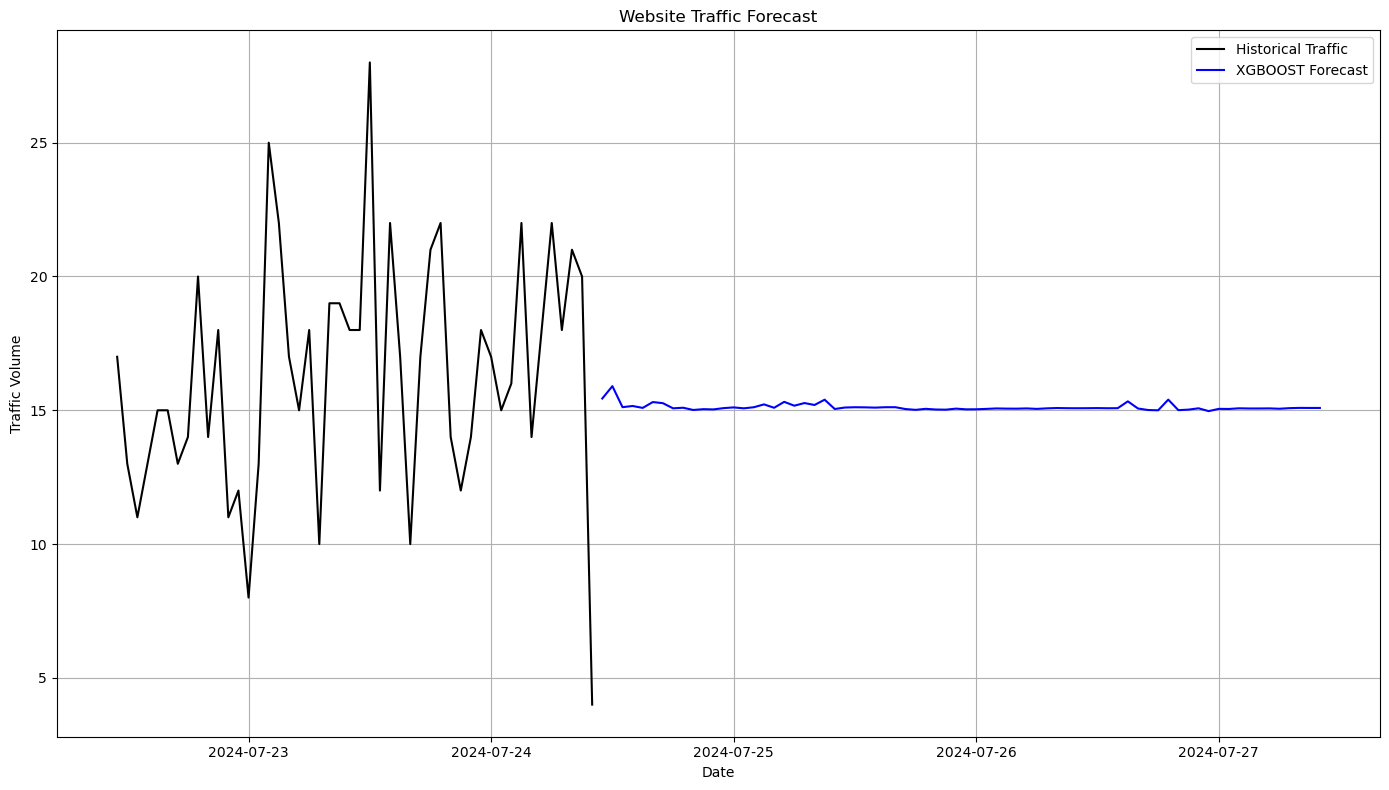

In [ ]:
# Forecast next 72 hours (3 days)
forecast = predictor.forecast_future_traffic(model_name=best_model, hours=72)

# Plot forecasts
predictor.plot_forecasts()

In [ ]:
# Identify peak times
print("Predicted Peak Traffic Times:")

peaks = predictor.identify_peak_times(forecast)
peaks

Predicted Peak Traffic Times:


KeyError: 'n'